In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import random
import scipy
from scipy import optimize
from scipy import linalg

import lies

In [2]:
img0 = 'k0.jpg'
img1 = 'k1.jpg'
img2 = 'k2.jpg'

In [3]:
def imgval(I, p):
    h,w = I.shape
    x = int(p[0] / p[2])
    y = int(p[1] / p[2])
    if x < 0 or x >= w or y < 0 or y >= h:
        return math.nan
    return float(I[y,x])

def slamResiduals(Ii, Ij, p, xi, Ki, Kj):
    four, k = p.shape
    r = 0
    xim = lies.so3exp(xi[3:])
    pi = Ki @ p
    pj = Kj @ (xim @ p + xi[:3, np.newaxis])
    bad = 0

    for i in range(k):
        ri = imgval(Ii, pi[:, i]) - imgval(Ij, pj[:, i])
        if math.isnan(ri):
            bad += 1
        else:
            r += ri * ri
    if bad > k/2:
        return math.inf

    #print("bad: ", bad, "/", k)

    return r / (k - bad)

def slamResidualMatches(p, xi, Kj, ref):
    xim = lies.so3exp(xi)
    pj = Kj @ (xim @ p + xi[:3, np.newaxis])
    pjn = pj[:1,:] / pj[2,:]
    
    return np.linalg.norm(pjn - ref)
    


In [4]:
px0 = cv.imread(img0, 0)
px1 = cv.imread(img1, 0)
px2 = cv.imread(img2, 0)

In [5]:
#Camera matrices

# TODO calibrate camera
K0 = np.array([[3000, 0, 920], [0, 3000, 1632], [0, 0, 1]])
K1 = np.array([[3000, 0, 920], [0, 3000, 1632], [0, 0, 1]])

# Inverse of camera matrices
L0 = np.linalg.inv(K0) # require square camera matrix (so without the fourth all zero column), that will return 1 on the z coordinate
L1 = np.linalg.inv(K1)


In [6]:
# TODO measure camera distance in stereo frame
trans01 = np.array([0.15, 0, 0, 0, 0, 0])
B = np.linalg.norm(trans01)

In [7]:
# Find keypoints
sift = cv.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(px0, None)
kp1, des1 = sift.detectAndCompute(px1, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Find matches between the two images by the means of some dark magic
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

good = []
pts1 = []
pts0 = []

# ratio test as per Lowe's paper
lowe = 0.6
for i, (m, n) in enumerate(matches):
    if m.distance < lowe * n.distance:
        good.append(m)
        pts1.append(kp1[m.trainIdx].pt)
        pts0.append(kp0[m.queryIdx].pt)


In [8]:
# Finding world points of keypoints

# Constructing depth map from two images with known translation of camera.

pts0 = np.int32(pts0)
pts1 = np.int32(pts1)
k, two = pts0.shape

# screen points with homogeneous coordinates
pts0hom = np.array([pts0[:,0], pts0[:,1], np.ones((k))])
pts1hom = np.array([pts1[:,0], pts1[:,1], np.ones((k))])

# disparity and depth
disp = np.linalg.norm((L1 @ pts1hom) - (L0 @ pts0hom), axis=0)
depth = B / disp # consider translation direction in B maybe?

# world points
p = L0 @ pts0hom * depth
# obviously not working, as my camera calibration and translation is bad, need to test if it works with proper measurements
print(p.transpose()[:15])

[[-0.32895838 -0.21625968  1.1422166 ]
 [-0.14446305  0.14554113  0.53904123]
 [-0.14435657  0.14561969  0.54133715]
 [-0.14432117  0.14578081  0.54736223]
 [-0.26830347  0.25090376  1.04398237]
 [-0.19270681 -0.33868159  0.75374241]
 [-0.24537825 -0.09279284  0.98020607]
 [-0.18983199 -0.32261204  0.76751476]
 [-0.24008553 -0.09695132  0.98261473]
 [-0.24008553 -0.09695132  0.98261473]
 [-0.19288609 -0.28879482  0.80146575]
 [-0.22521899 -0.07852591  1.00245842]
 [-0.21930714  0.33287084  1.02003322]
 [-0.08338252  0.14778472  0.39269632]
 [-0.08338252  0.14778472  0.39269632]]


187
(3264, 1840)


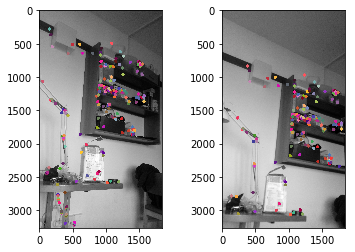

In [9]:
#print (pts0[:15,], pts1[:15,], disp[:15], depth[:15])
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
for i in range(nn):
    colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = i#random.randint(0, nn-1)
    #print(tuple(pts0[j,:].astype(int).tolist()), tuple(pts1[j,:].astype(int).tolist()), disp[j], depth[j])
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(121),plt.imshow(px0p)
plt.subplot(122),plt.imshow(px1p)
plt.show()

In [10]:
# Trying to determine camera movement between images, 
xi0 = np.array([.0,.00,0.0,0.0,0.0,0.0])

xi = scipy.optimize.fmin(lambda xi: slamResiduals(px0, px2, p, xi, K0, K1), xi0)
#xi = slam.slamStepIterate(px0, px2, p, xi0, 100)

print(xi)
# FAIL (obviously)

Optimization terminated successfully.
         Current function value: 5334.101604
         Iterations: 34
         Function evaluations: 97
[ 2.03620263e-04 -1.91414475e-04  1.31302543e-04  1.36061964e-04
 -5.67163588e-05 -1.36222142e-04]


In [11]:
# Elimination of outlier points using fundamental matrix

F, mask = cv.findFundamentalMat(pts1,pts0,cv.FM_LMEDS)
print(F)

# We select only inlier points
pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]

[[ 5.37649784e-09 -2.76148241e-07  6.98837575e-04]
 [ 3.42460952e-07  8.74427116e-08  9.57323846e-04]
 [-7.00222924e-04 -1.37905101e-03  1.00000000e+00]]


136
(3264, 1840)


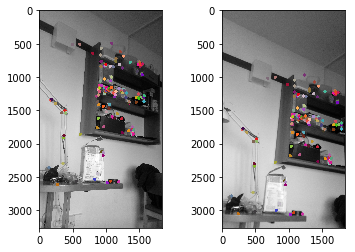

In [12]:
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
for i in range(nn):
    colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = i#random.randint(0, nn-1)
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(121),plt.imshow(px0p)
plt.subplot(122),plt.imshow(px1p)
plt.show()

In [13]:
# Trying to determine camera movement between images, 
xi0 = np.array([.0,.00,0.0,0.0,0.0,0.0])

xi = scipy.optimize.fmin(lambda xi: slamResiduals(px0, px2, p, xi, K0, K1), xi0)
#xi = slam.slamStepIterate(px0, px2, p, xi0, 100)

print(xi)
# still FAIL
# let's try something else

Optimization terminated successfully.
         Current function value: 5334.101604
         Iterations: 34
         Function evaluations: 97
[ 2.03620263e-04 -1.91414475e-04  1.31302543e-04  1.36061964e-04
 -5.67163588e-05 -1.36222142e-04]


In [14]:
# Find matches again, but this time between three images

# Find keypoints. This will be useful in slam even if there aren't many matches.
sift = cv.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(px0, None)
kp1, des1 = sift.detectAndCompute(px1, None)
kp2, des2 = sift.detectAndCompute(px2, None)
# would compressing the images result in more or less matches? It would defo make the matcher run faster
# can this find matches between images taken by two different cameras

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# find matckes between keypoints in pairs of images. 
# The matches will reference the keypoints, so we can pick up some matches between all three images
flann = cv.FlannBasedMatcher(index_params, search_params)
# OpenCV is terribly documented. The knnMatch function doesn't even exist in the documentation
matches01 = flann.knnMatch(des1, des0, k=2)
matches02 = flann.knnMatch(des2, des0, k=2)

good01 = {}

# ratio test as per Lowe's paper
# ^this comment is from the OpenCV tutorial. I have not read, or even found, Lowe's paper
lowe = 0.8
# the ratio test isn't really good to remove outliers. We will construct a fundamental matrix and use that
for i, (m, n) in enumerate(matches01):
    if m.distance < lowe * n.distance:
        good01[m.trainIdx] = m
        
pts0 = []
pts1 = []
pts2 = []
        
# Finding matches between all three images. 
for i, (m, n) in enumerate(matches02):
    if m.distance < lowe * n.distance:
        if m.trainIdx in good01:
            pts0.append(kp0[m.trainIdx].pt)
            pts1.append(kp1[good01[m.trainIdx].queryIdx].pt)
            pts2.append(kp2[m.queryIdx].pt)
        
pts0 = np.int32(pts0)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print(pts0.shape)

(46, 2)


In [15]:
# we should already know this matrix? Wierdly, we get something different than last time.
F01, mask = cv.findFundamentalMat(pts1,pts0,cv.FM_LMEDS)
print(F01)

# We select only inlier points
pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


F02, mask = cv.findFundamentalMat(pts2,pts0,cv.FM_LMEDS)
print(F02)

pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[[-3.74495183e-09 -6.46025053e-07  1.35510976e-03]
 [ 6.86442777e-07  1.02008295e-07  7.06715694e-04]
 [-1.15251522e-03 -1.20981687e-03  1.00000000e+00]]
[[ 1.22966552e-07  8.13236023e-07 -1.04931088e-03]
 [-6.70711697e-07 -8.60942402e-09  5.23849739e-04]
 [-9.11323304e-05 -7.92011848e-04  1.00000000e+00]]


24
(3264, 1840)


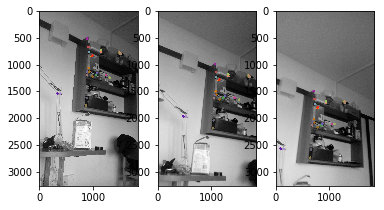

In [16]:
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
px2p = cv.cvtColor(px2, cv.COLOR_GRAY2BGR)
for i in range(nn):
    colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = i#random.randint(0, nn-1)
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    px2p = cv.circle(px2p, tuple(pts2[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(131),plt.imshow(px0p)
plt.subplot(132),plt.imshow(px1p)
plt.subplot(133),plt.imshow(px2p)
plt.show()

In [17]:
# calculate essential matrix
E = K0.transpose() @ F02 @ K0
print(E)

[[ 1.10669896  7.31912421  1.17305861]
 [-6.03640527 -0.07748482 -0.32176681]
 [-3.21781377 -0.17365586 -0.19170825]]


In [18]:
# Trying to get camera movement and rotation based on the essential matrix
# In theory, we can get the direction of the movement (not magnitude, and may be opposite direction)
# We can also get the rotation matrix but there are two possible solutions and we can not tell which one is correct

W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
Wt = W.transpose()

# get null space of essential matrix 
# there's another formula on Wikipedia, but that doesn't give a skew-symmetric cross product matrix. Maybe because of camera calibration
U,s,Vt = scipy.linalg.svd(E)
nullmask = (s <= 1e-7)
t = scipy.compress(nullmask, Vt, axis=0)[0]

# finding rotation matrix and corresponding so(3) lie algebras
Ra = U @ Wt @ Vt
Rb = U @ W @ Vt
rota = lies.so3log(Ra)
rotb = lies.so3log(Rb)

print("t=",t)
# Eigenvalues should be two identical and a zero. They do not seem identical to me
print("s=",s)
# Multiplying the rotation matrix with the cross product matrix does not return the original E??
print("[t]× R=",np.transpose(np.cross(t, Ra.transpose())))
print("rota=",rota)

t= [-0.05069454 -0.15057202  0.9872984 ]
s= [7.85995311e+00 6.43121495e+00 5.65523519e-08]
[t]× R= [[ 0.04812593  0.87990825  0.46997386]
 [-0.98778499  0.03667226  0.01624914]
 [-0.14817512  0.05077326  0.02660976]]
rota= [0.06908452 0.97110528 2.92738872]


In [19]:
# Finding world points of keypoints again

k, two = pts0.shape

# image points with homogeneous coordinates
pts0hom = np.array([pts0[:,0], pts0[:,1], np.ones((k))])
pts1hom = np.array([pts1[:,0], pts1[:,1], np.ones((k))])

# disparity and depth
disp = np.linalg.norm((L1 @ pts1hom) - (L0 @ pts0hom), axis=0)
depth = B / disp

# world points
p = L0 @ pts0hom * depth

# Reference for residuals matching
ref = pts2.transpose()

In [20]:
# SLAM match image intensities using translation direction and rotation obtained from SVD of essential matrix
# doesn't work, probably slamResiduals is bad
s = scipy.optimize.fmin(lambda l: slamResiduals(px0, px2, p, np.concatenate([t * l[0], rota]), K0, K0), [0.0])

/usr/lib/python3.6/site-packages/scipy/optimize/optimize.py:543: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [21]:
# Slam match residuals using translation direction and rotation obtained from SVD of essential matrix
#no idea how to determine if we need Ra or Rb

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([t * l[0], rota]), K0, ref), [0.0])
print(t * s)

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([t * l[0], rotb]), K0, ref), [0.0])
print(t * s)

Optimization terminated successfully.
         Current function value: 5584.081924
         Iterations: 20
         Function evaluations: 40
[ 0.00979672  0.02909804 -0.19079542]
Optimization terminated successfully.
         Current function value: 5501.024922
         Iterations: 21
         Function evaluations: 42
[ 0.01646305  0.04889826 -0.32062516]


In [22]:
# SLAM match residuals without using essential matrix decomposed translation vector

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([t, rota]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([t, rotb]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([-t, rota]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.concatenate([-t, rotb]))
print(xi)

xi = scipy.optimize.fmin(lambda xi: slamResidualMatches(p, xi, K0, ref), np.array([0, 0, 0, 0, 0, 0]))
print(xi)

# seems to converge to different values from different starting points
# Maximum number of function evaluations has been exceeded. often
# maybe use Gauss-Newton from original LSD-SLAM paper?
# we need accurate transformation measurements and camera calibration to proceed!

[  0.34719406 -20.12447377   3.4947796   -6.4291551  -54.86510873
  16.64008247]
Optimization terminated successfully.
         Current function value: 4673.686830
         Iterations: 351
         Function evaluations: 574
[0.00617722 2.22384999 0.00232777 2.13602188 0.21301867 0.60163666]
Optimization terminated successfully.
         Current function value: 4597.296994
         Iterations: 372
         Function evaluations: 589
[ 0.32683391 -2.00791931 -0.38569788 -0.08905561  1.52339361 -0.27970635]
Optimization terminated successfully.
         Current function value: 4597.265080
         Iterations: 326
         Function evaluations: 518
[ 0.47047287 -1.94094958 -0.5109592   1.14705785 -0.01467741  0.36924128]
Optimization terminated successfully.
         Current function value: 4943.665993
         Iterations: 444
         Function evaluations: 710
[-0.14443036  0.26598402 -0.12514358 -0.04660629 -0.02505647  0.07466492]
